In [8]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt

# Logistic regression

In [9]:
# generate data

def uni_gaussian(m, s):
    U = np.random.uniform(low=0.0, high=1.0)
    V = np.random.uniform(low=0.0, high=1.0)
    Z = math.sqrt(-2*math.log(U))*math.cos(2*math.pi*V)
    return m+Z*s**(0.5)


def generate_data(N, mx, vx, my, vy):
    D = np.zeros((N,2))
    
    for i in range(N):
        D[i,0] = uni_gaussian(mx,vx)
        D[i,1] = uni_gaussian(my,vy)
    return D

In [10]:
C0 = generate_data(5, 1,2,1,2)
C1 = generate_data(5, 1,2,1,2)

In [11]:
C0

array([[ 0.73886381,  1.84462476],
       [ 0.71853279,  0.99184138],
       [-0.11667058,  1.02181984],
       [ 1.16285669,  1.60806788],
       [ 2.24959967,  3.35458214]])

In [12]:
C1

array([[ 1.78420643,  0.33404073],
       [ 1.89050106, -0.58235071],
       [ 0.89106122,  1.0110914 ],
       [-0.22186592,  0.26405164],
       [-0.40439384,  0.65855636]])

In [13]:
# confusion matrix
def confusion_matrix(A,b,predict):
    '''
    TP  FN 
    FP  TN 
    A: (2N,3) shape matrix
    b: (2N,1) shape matrix
    predict: (2N,1) shape matrix
    return: (confusion_matix, points to be class0, points to be class1)
    class 1 = positive
    class 0 = negative
    '''
    ans_pair = np.hstack((b,predict))
    TP=FP=FN=TN=0
    for pair in ans_pair:
        if pair[0]==pair[1]==1:
            TP+=1
        elif pair[0]==pair[1]==0:
            TN+=1
        elif pair[0]==1 and pair[1]==0:
            FN+=1            
        else:
            FP+=1
    c_matrix = np.zeros((2,2))
    c_matrix[0,0]=TP
    c_matrix[0,1]=FN
    c_matrix[1,0]=FP
    c_matrix[1,1]=TN

    
    return c_matrix

def print_confusion(matrix):    
    #class 1 = cluster 1 
    #class 0 = cluster 2
    print('Confusion Matrix:')
    print('               Predict cluster 1  Predict cluster 2')
    print('Is cluster 1        {:.0f}               {:.0f}       '.format(matrix[0,0],matrix[0,1]))
    print('Is cluster 2        {:.0f}               {:.0f}       '.format(matrix[1,0],matrix[1,1]))
    print()
    print('Sensitivity (Successfully predict cluster 1): {}'.format(matrix[0,0]/(matrix[0,0]+matrix[0,1])))
    print('Specificity (Successfully predict cluster 2): {}'.format(matrix[1,1]/(matrix[1,0]+matrix[1,1])))

In [14]:
# utility

def get_A(d0,d1):
    A = np.ones((2 * len(d0), 3))
    A[:, 1:] = np.vstack((d0, d1))
    return A
'''
A = [[1,d0_x,d0_y],
     [1,d1_x,d0_y]]
上下疊一起
'''

def get_truth(N):
    b = np.zeros((2 * N, 1))
    b[N:] = np.ones((N, 1))
    return b

def get_predict_class(A, b_pre):
    C0_predict=[]
    C1_predict=[]
    for i in range(len(A)):
        if b_pre[i]==0:
            C0_predict.append(A[i,1:])
        else:
            C1_predict.append(A[i,1:])
    return np.array(C0_predict), np.array(C1_predict)

In [15]:
A= get_A(C0,C1)
len(A)

10

In [16]:
A[2]

array([ 1.        , -0.11667058,  1.02181984])

Gradient descent of logistic regression

https://dphi.tech/blog/tutorial-on-logistic-regression-using-python/

In [17]:
# Gradient descent

def gradient(A, b, lr=0.05, w=np.random.rand(3,1), eps = 1e-3):
    g = 10
    iteration = 0
    while np.sqrt(np.sum(g**2))>eps and iteration <20000: # >eps?
        g = A.T@(b - 1/(1+np.exp(-A@w)))
        w = w + lr*g
        iteration += 1
    return w
    
    '''
    return weights
    '''

Newton & Hessian

https://thelaziestprogrammer.com/sharrington/math-of-machine-learning/solving-logreg-newtons-method

In [18]:
# Newton's

def newtons(A,b,lr=0.05, w=np.random.rand(3,1), eps = 1e-3):
    N = len(A)
    # desing matrix
    D = np.zeros((N,N))
    for i in range(N):
        D[i,i]= np.exp(-A[i]@w)/(1+np.exp(-A[i]@w))**2
    H=A.T@D@A
    try:
        inv_H = np.linalg.inv(H)
    except np.linalg.LinAlgError as err:
        print(str(err))
        print('The Hessian matrix is not inversible!')
    g = 10
    iteration = 0
    while np.sqrt(np.sum(g**2))>eps and iteration <20000 : # >eps?
        g = inv_H@A.T@(b - 1/(1+np.exp(-A@w)))
        w = w + lr*g
        iteration += 1
    return w

In [19]:
# predict

def predict(A,w):
    '''
    predict whether is class0 or class1
    class 1 = cluster 1 
    class 0 = cluster 2
    A: (2N,3), w: (3,1) 
    return (2N,1) as prediction
    '''
    N=len(A)
    predict=np.empty((N,1))
    for i in range(N):
        if A[i]@w <0:
            predict[i]=0
        else:
            predict[i]=1
    return predict


In [20]:
# plot
def data_class(A,predict):
    for i in range(len(A)):
        class_0=[]
        class_1=[]
        if predict[i]==0:
            class_0.append(A[i,1:])
        else:
            class_1.append(A[i,1:])
    
    return np.array(class_0),np.array(class_1)

def plot(C0,C1,title):
    plt.figure()
    plt.plot(C0[:,0],C0[:,1],'ro')
    plt.plot(C1[:,0],C1[:,1],'bo')
    plt.title(title)
    plt.show()

# print weight

def print_weight(w):
    print('w:')
    print(w[0])
    print(w[1])
    print(w[2])



In [22]:
# main

mx1, my1, mx2, my2, vx1, vy1, vx2, vy2 = 1, 1, 10, 10, 2, 2, 2, 2
N = 50


def logistic_regression(N, mx1, my1, mx2, my2, vx1, vy1, vx2, vy2):
    # sampling data
    C0 = generate_data(N, mx1, vx1, my1, vy1)
    C1 = generate_data(N, mx2, vx2, my2, vy2)

    # initailize
    A = get_A(C0, C1)
    b = get_truth(N)
    # plot ground truth
    plot(C0, C1, 'Ground truth')

    # gradient
    w = gradient(A, b, lr=0.05, w=np.random.rand(3, 1), eps=1e-2)
    
    # print & plot
    g_prediction = predict(A,w)
    c_matrix = confusion_matrix(A,b,g_prediction)
    g_C0, g_C1 = get_predict_class(A, g_prediction)

    print('Gradient descent:\n')
    print_weight(w)
    print_confusion(c_matrix)
    plot(g_C0, g_C1, 'Gradient descent')
    

    print('\n----------------------------------------')
    
    
    # Newton's
    w = newtons(A,b,lr=0.05, w=np.random.rand(3,1), eps = 1e-2)
    
    # print & plot
    n_prediction = predict(A,w)
    c_matrix = confusion_matrix(A,b,n_prediction)
    n_C0, n_C1 = get_predict_class(A, n_prediction)
    print("Newton's method:\n")
    print_weight(w)
    print_confusion(c_matrix)
    plot(n_C0, n_C1, "Newton's method")
    

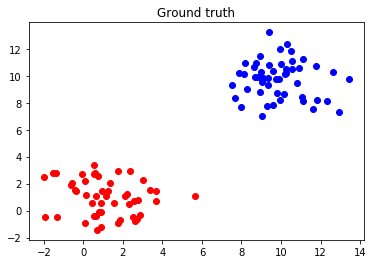

Gradient descent:

w:
[-14.34833174]
[0.76870897]
[2.10707741]
Confusion Matrix:
               Predict cluster 1  Predict cluster 2
Is cluster 1        50               0       
Is cluster 2        0               50       

Sensitivity (Successfully predict cluster 1): 1.0
Specificity (Successfully predict cluster 2): 1.0


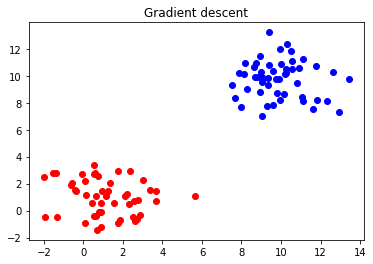


----------------------------------------
Newton's method:

w:
[-9.71074398]
[0.73303078]
[1.22387735]
Confusion Matrix:
               Predict cluster 1  Predict cluster 2
Is cluster 1        50               0       
Is cluster 2        0               50       

Sensitivity (Successfully predict cluster 1): 1.0
Specificity (Successfully predict cluster 2): 1.0


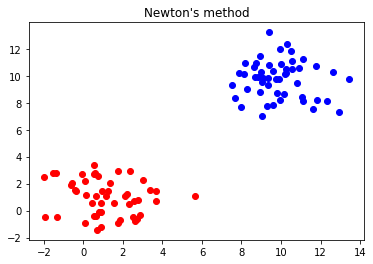

In [23]:
logistic_regression(N, mx1, my1, mx2, my2, vx1, vy1, vx2, vy2)

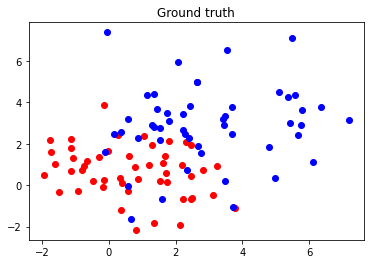

Gradient descent:

w:
[-4.22120643]
[2.90758214]
[3.03709656]
Confusion Matrix:
               Predict cluster 1  Predict cluster 2
Is cluster 1        47               3       
Is cluster 2        25               25       

Sensitivity (Successfully predict cluster 1): 0.94
Specificity (Successfully predict cluster 2): 0.5


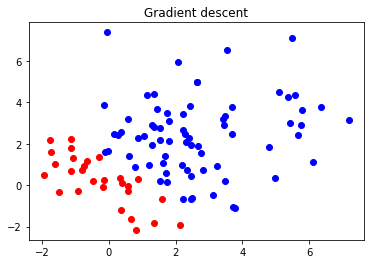


----------------------------------------
Newton's method:

w:
[-2.9415245]
[0.84802854]
[0.94243439]
Confusion Matrix:
               Predict cluster 1  Predict cluster 2
Is cluster 1        41               9       
Is cluster 2        8               42       

Sensitivity (Successfully predict cluster 1): 0.82
Specificity (Successfully predict cluster 2): 0.84


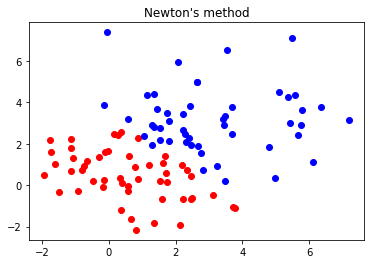

In [100]:
mx1, my1, mx2, my2, vx1, vy1, vx2, vy2 = 1, 1, 3, 3, 2, 2, 4, 4
N = 50

logistic_regression(N, mx1, my1, mx2, my2, vx1, vy1, vx2, vy2)